# Machine Learning Code for Capstone

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.stats import pearsonr 
import math
from pylab import *

#### Read in TSV Data.  Format Salary field properly.

In [3]:
df_total = pd.read_csv('test_player_dataframe_1.txt',sep='\t')

df_total.Salary = df_total['Salary'].str.replace('$','')
df_total.Salary = df_total['Salary'].str.replace(',','')
df_total.Salary = df_total['Salary'].astype(float)

## Multiply by the 2018 NBA Salary cap of $102M
df_total['Salary_2018'] = df_total['Salary%']*102000000

### Create Weighted Average Dataframe 
Create a dataframe that represents the weighted averages of each player's seasons on their rookie contract.  This will give us a representation of their body of work up until the point of their new contract.  Store the player's new non-rookie contract in the same row so we can see the relationships between the weighted averages of statistics and their new contract.

In [4]:
players = df_total['Player'].unique()

list_of_rookie_contract_data = []
list_of_first_contract_data = []
list_of_columns_to_average = ['Age','G','GS','MP_x','FG','FGA',
 'FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%','FT','FTA','FT%','ORB',
 'DRB','TRB','AST','STL','BLK','TOV','PF','PTS','MP_y','PER','TS%','3PAr',
 'FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS',
 'WS','WS/48','OBPM','DBPM','BPM','VORP']
list_of_averaged_rows = []

#For each player in original dataset, create a Rookie table of just his first 4 seasons
#Also create a Contract datatable of his first year with the new contract
for player in players:
    df_player = df_total[df_total['Player'] == player]
    df_player_rookie = df_player.iloc[0:3]
    df_player_contract = df_player.iloc[4:5]
#Append these individual dataframes to separate lists, they will later be concatendated into one larger dataframe    
    list_of_rookie_contract_data.append(df_player_rookie)
    list_of_first_contract_data.append(df_player_contract)

#############################################################################################
# Create a dataframe of the weight averages of numerical columns during players first 4 seasons
#############################################################################################    
    weight_array =[]
    total_minutes = 0
    for index, row in df_player_rookie.iterrows():
        #The weight used will be based off minutes played for each seasons
        weight = row.MP_x * row.G
        #Make an array of the weights for each season
        weight_array.append(weight)
        total_minutes = weight + total_minutes
    #If they didn't play in a given season, skip    
    if total_minutes == 0:
        continue
    #Normalize the weight array    
    weight_array[:] = [x / total_minutes for x in weight_array]

    ##Iterate through the new Rookie dataframe, apply weighted average for numerical columns
    ##If column is Salary, grab it from the Contract table
    ##If column is non-numeric, just add a placeholder value to the row
    new_row = []
    if len(df_player) <5:
        continue
    for column in df_player_rookie.columns:        
        if column in list_of_columns_to_average:
            new_row.append(np.dot(weight_array,df_player_rookie[column]))
        elif column == 'Salary':
            new_row.append(df_player.iloc[4:5]['Salary'].values[0])
        elif column == 'Salary%':
            new_row.append(df_player.iloc[4:5]['Salary%'].values[0])    
        elif column == 'Salary_2018':
            new_row.append(df_player.iloc[4:5]['Salary_2018'].values[0])  
        else:
            var = df_player_rookie.iloc[:-2][column].values[0]
            new_row.append(var)
    list_of_averaged_rows.append(new_row)
list_of_averaged_rows = pd.Series(list_of_averaged_rows)

##Make the larger rookie and contract dataframes
df_rookie_total = pd.concat(list_of_rookie_contract_data)
df_contract_total = pd.concat(list_of_first_contract_data)
##Make the larger rookie_averages dataframe
df_rookie_averages = pd.DataFrame.from_items(zip(list_of_averaged_rows.index,list_of_averaged_rows.values)).T
df_rookie_averages.columns = list(df_total.columns.values)

## Train-Test Split - General Linear Regression Model

In [40]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from math import sqrt

target = pd.DataFrame(df_rookie_averages['Salary_2018'])
independent_vars = df_rookie_averages.loc[:,['PTS','AST','TRB','BLK','DWS','Age']]
independent_vars.astype(float)
independent_vars.dropna(inplace=True)
independent_vars = sm.add_constant(independent_vars)

X_train, X_test, y_train, y_test = train_test_split(independent_vars, target, test_size=0.2)


model = sm.OLS(list(y_train['Salary_2018'].astype(float)),X_train.astype(float)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     180.5
Date:                Mon, 09 Jul 2018   Prob (F-statistic):          3.02e-131
Time:                        21:17:18   Log-Likelihood:                -10256.
No. Observations:                 612   AIC:                         2.053e+04
Df Residuals:                     605   BIC:                         2.056e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       8.718e+06   2.86e+06      3.049      0.002       3.1e+06  1.43e+07
PTS          6.81e+05   6.61e+04     10.301      0.000      5.51e+05  8.11e+05
AST         2.835e+05   1.68e+05      1.685      0.093      -4.7e+04  6.14e+05
TRB         2.624e+05   1.58e+05      1.663      0.097     -4.74e+04  5.72e+05
BLK         2.218e+06   5.28e+05      4.203      0.000      1.18e+06  3.25e+06
DWS         1.969e+06   3.06e+05      6.442      0.000      1.37e+06  2.57e+06
Age        -4.874e+05    1.2e+05     -4.051      0.000     -7.24e+05 -2.51e+05
==============================================================================
Omnibus:                       45.271   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.741
Skew:                           0.338   Prob(JB):                     3.01e-28
Kurtosis:                       5.125   Cond. No.                         385.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt

predictions = model.predict(X_test)

rmse = sqrt(mean_squared_error(np.array(y_test), np.array(predictions)))
print("RMSE: ",rmse)

RMSE:  4675714.773709403


## General Model (No Train-Test Split)

In [8]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

target = pd.DataFrame(df_rookie_averages['Salary_2018'])
independent_vars = df_rookie_averages.loc[:,['PTS','AST','TRB','BLK','DWS','Age']]
independent_vars.astype(float)
independent_vars.dropna(inplace=True)
independent_vars.describe()

independent_vars = sm.add_constant(independent_vars)
model = sm.OLS(list(target['Salary_2018'].astype(float)),independent_vars.astype(float)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     231.2
Date:                Mon, 09 Jul 2018   Prob (F-statistic):          1.50e-167
Time:                        20:42:53   Log-Likelihood:                -12838.
No. Observations:                 766   AIC:                         2.569e+04
Df Residuals:                     759   BIC:                         2.572e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       7.937e+06   2.58e+06      3.075      0.002      2.87e+06   1.3e+07
PTS         7.123e+05   5.89e+04     12.095      0.000      5.97e+05  8.28e+05
AST         3.463e+05   1.51e+05      2.291      0.022      4.95e+04  6.43e+05
TRB         3.316e+05   1.45e+05      2.294      0.022      4.79e+04  6.15e+05
BLK         1.869e+06   4.81e+05      3.882      0.000      9.24e+05  2.81e+06
DWS          1.86e+06   2.74e+05      6.777      0.000      1.32e+06   2.4e+06
Age        -4.667e+05   1.09e+05     -4.284      0.000     -6.81e+05 -2.53e+05
==============================================================================
Omnibus:                       64.742   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.619
Skew:                           0.377   Prob(JB):                     1.00e-44
Kurtosis:                       5.404   Cond. No.                         388.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Root Mean Squared Error for Generic Model

In [232]:
print("Root Mean Squared Error")
print(sqrt(mean_squared_error(target['Salary_2018'].astype(float),model.predict(independent_vars.astype(float)))))

Root Mean Squared Error
4599388.877109679


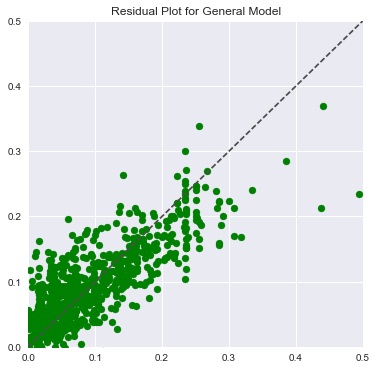

In [227]:
f, ax = plt.subplots(figsize=(6, 6))

plt.scatter(target, model.predict(), color="g", label="Linear")

ax.plot([0, 0.5], [0, 0.5], ls="--", c=".3")
ax.set(xlim=(0,0.5), ylim=(0,0.5))
plt.title('Residual Plot for General Model')
plt.show()

## Ensemble Model Approach

##### Break up dataframe into position specific smaller dataframes

In [233]:
df_big_men_averages = df_rookie_averages[(df_rookie_averages.Pos == 'PF')|(df_rookie_averages.Pos == 'C')]
df_wings_averages = df_rookie_averages[(df_rookie_averages.Pos == 'SF')|(df_rookie_averages.Pos == 'SG')]
df_pointguard_averages = df_rookie_averages[(df_rookie_averages.Pos == 'PG')]

### Point Guard Specific Sub-model

In [234]:
import statsmodels.api as sm

target = pd.DataFrame(df_pointguard_averages['Salary_2018'])
pg_independent_vars = df_pointguard_averages.loc[:,['3P','AST','ORB','BLK']]
pg_independent_vars.astype(float)
pg_independent_vars.dropna(inplace=True)
pg_independent_vars.describe()

pg_independent_vars = sm.add_constant(pg_independent_vars)
pg_model = sm.OLS(list(target['Salary_2018'].astype(float)),pg_independent_vars.astype(float)).fit()

pg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     56.48
Date:                Wed, 04 Jul 2018   Prob (F-statistic):           1.21e-28
Time:                        09:45:42   Log-Likelihood:                -2511.9
No. Observations:                 150   AIC:                             5034.
Df Residuals:                     145   BIC:                             5049.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -2.619e+06   9.01e+05     -2.906      0.004      -4.4e+06 -8.38e+05
3P          1.995e+06   7.69e+05      2.594      0.010      4.75e+05  3.51e+06
AST         1.572e+06   2.28e+05      6.907      0.000      1.12e+06  2.02e+06
ORB         3.651e+06   1.42e+06      2.575      0.011      8.49e+05  6.45e+06
BLK         1.291e+07   3.37e+06      3.830      0.000      6.25e+06  1.96e+07
==============================================================================
Omnibus:                        2.905   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.234   Jarque-Bera (JB):                3.059
Skew:                           0.015   Prob(JB):                        0.217
Kurtosis:                       3.699   Cond. No.                         41.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

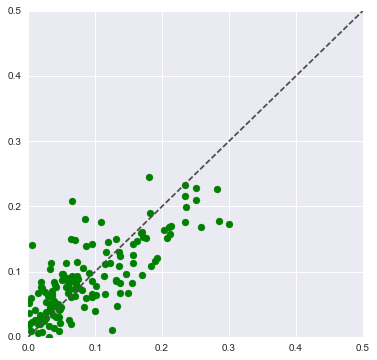

In [136]:
f, ax = plt.subplots(figsize=(6, 6))

plt.scatter(target, pg_model.predict(), color="g", label="Linear")

ax.plot([0, 0.5], [0, 0.5], ls="--", c=".3")
ax.set(xlim=(0,0.5), ylim=(0,0.5))
plt.show()

### Big Man Specific Sub-model

In [235]:
import statsmodels.api as sm

target = pd.DataFrame(df_big_men_averages['Salary_2018'])
bm_independent_vars = df_big_men_averages.loc[:,['3P','AST','ORB','BLK','TOV']]
bm_independent_vars.astype(float)
bm_independent_vars.dropna(inplace=True)
bm_independent_vars.describe()

bm_independent_vars = sm.add_constant(bm_independent_vars)
big_man_model = sm.OLS(list(target['Salary_2018'].astype(float)),bm_independent_vars.astype(float)).fit()

big_man_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     98.91
Date:                Wed, 04 Jul 2018   Prob (F-statistic):           6.35e-63
Time:                        09:46:02   Log-Likelihood:                -5528.6
No. Observations:                 328   AIC:                         1.107e+04
Df Residuals:                     322   BIC:                         1.109e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -3.812e+06   7.23e+05     -5.268      0.000     -5.23e+06 -2.39e+06
3P          1.951e+06   1.16e+06      1.680      0.094     -3.34e+05  4.24e+06
AST         1.153e+06   7.21e+05      1.599      0.111     -2.65e+05  2.57e+06
ORB         2.329e+06   5.43e+05      4.287      0.000      1.26e+06   3.4e+06
BLK         2.847e+06   5.81e+05      4.904      0.000       1.7e+06  3.99e+06
TOV         4.688e+06   9.28e+05      5.054      0.000      2.86e+06  6.51e+06
==============================================================================
Omnibus:                       19.392   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.590
Skew:                           0.218   Prob(JB):                     4.63e-11
Kurtosis:                       4.814   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

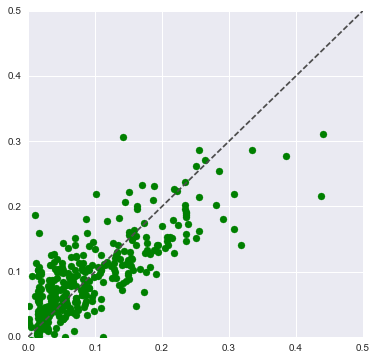

In [142]:
f, ax = plt.subplots(figsize=(6, 6))

plt.scatter(target, big_man_model.predict(), color="g", label="Linear")

ax.plot([0, 0.5], [0, 0.5], ls="--", c=".3")
ax.set(xlim=(0,0.5), ylim=(0,0.5))
plt.show()

### Wing Specific Sub-model

In [236]:
import statsmodels.api as sm

target = pd.DataFrame(df_wings_averages['Salary_2018'])
wing_independent_vars = df_wings_averages.loc[:,['3P','AST','ORB','BLK']]
wing_independent_vars.astype(float)
wing_independent_vars.dropna(inplace=True)
wing_independent_vars.describe()

wing_wing_independent_vars = sm.add_constant(wing_independent_vars)
wing_model = sm.OLS(list(target['Salary_2018'].astype(float)),wing_independent_vars.astype(float)).fit()

wing_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     265.0
Date:                Wed, 04 Jul 2018   Prob (F-statistic):           3.29e-94
Time:                        09:46:25   Log-Likelihood:                -4840.7
No. Observations:                 286   AIC:                             9689.
Df Residuals:                     282   BIC:                             9704.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
3P          2.771e+06   5.84e+05      4.747      0.000      1.62e+06  3.92e+06
AST         1.821e+06      3e+05      6.075      0.000      1.23e+06  2.41e+06
ORB         3.057e+06   6.42e+05      4.759      0.000      1.79e+06  4.32e+06
BLK         4.274e+06   1.23e+06      3.477      0.001      1.85e+06  6.69e+06
==============================================================================
Omnibus:                       65.009   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.467
Skew:                           1.087   Prob(JB):                     7.80e-34
Kurtosis:                       5.841   Cond. No.                         9.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

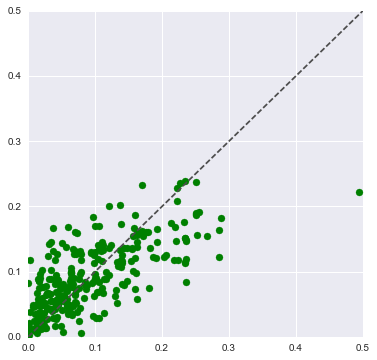

In [140]:
f, ax = plt.subplots(figsize=(6, 6))

plt.scatter(target, wing_model.predict(), color="g", label="Linear")

ax.plot([0, 0.5], [0, 0.5], ls="--", c=".3")
ax.set(xlim=(0,0.5), ylim=(0,0.5))
plt.show()

### General Sub Model
This is the part of the ensemble model that is not position specific.  It does not use variables used by the position specific sub models.

In [237]:
import statsmodels.api as sm

target = pd.DataFrame(df_rookie_averages['Salary_2018'])
independent_vars = df_rookie_averages.loc[:,['PTS','DWS','Age']]
independent_vars.astype(float)
independent_vars.dropna(inplace=True)
independent_vars.describe()

independent_vars = sm.add_constant(independent_vars)
gen_model = sm.OLS(list(target['Salary_2018'].astype(float)),independent_vars.astype(float)).fit()

gen_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     430.3
Date:                Wed, 04 Jul 2018   Prob (F-statistic):          1.78e-163
Time:                        09:46:37   Log-Likelihood:                -12857.
No. Observations:                 766   AIC:                         2.572e+04
Df Residuals:                     762   BIC:                         2.574e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       1.007e+07   2.61e+06      3.852      0.000      4.94e+06  1.52e+07
PTS         7.937e+05   4.46e+04     17.785      0.000      7.06e+05  8.81e+05
DWS         2.864e+06   2.17e+05     13.199      0.000      2.44e+06  3.29e+06
Age        -5.283e+05   1.11e+05     -4.768      0.000     -7.46e+05 -3.11e+05
==============================================================================
Omnibus:                       71.541   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.567
Skew:                           0.483   Prob(JB):                     4.16e-42
Kurtosis:                       5.244   Cond. No.                         378.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [238]:
print("Root Mean Squared Error")
print(sqrt(mean_squared_error(target['Salary_2018'].astype(float),gen_model.predict(independent_vars.astype(float)))))

Root Mean Squared Error
4711795.194053013


### Create the General components of all the position specific sub-models.

In [239]:
gen_model_pg_independent_vars = independent_vars = df_pointguard_averages.loc[:,['PTS','DWS','Age']]
gen_model_pg_independent_vars.astype(float)
gen_model_pg_independent_vars.dropna(inplace=True)
gen_model_pg_independent_vars = sm.add_constant(gen_model_pg_independent_vars)

gen_model_bm_independent_vars = independent_vars = df_big_men_averages.loc[:,['PTS','DWS','Age']]
gen_model_bm_independent_vars.astype(float)
gen_model_bm_independent_vars.dropna(inplace=True)
gen_model_bm_independent_vars = sm.add_constant(gen_model_bm_independent_vars)

gen_model_wing_independent_vars = independent_vars = df_wings_averages.loc[:,['PTS','DWS','Age']]
gen_model_wing_independent_vars.astype(float)
gen_model_wing_independent_vars.dropna(inplace=True)
gen_model_wing_independent_vars = sm.add_constant(gen_model_wing_independent_vars)

### Find weights for the general vs. position specific sub-models.
For each value of p, weight the general model and the position specific sub-models
From this weighted value, compute the root mean squared error against the actual data points
Calculate the average root mean squared error from all 3 position specific models.

In [240]:
from sklearn.metrics import mean_squared_error
from math import sqrt

for i in range (1,10):
    p=i/10
    pg_model_avg = p * pg_model.predict(pg_independent_vars) + (1-p) * gen_model.predict(gen_model_pg_independent_vars)
    weight_pg_rmse = sqrt(mean_squared_error(pg_model_avg,df_pointguard_averages['Salary_2018']))
    
    bm_model_avg = p * big_man_model.predict(bm_independent_vars) + (1-p) * gen_model.predict(gen_model_bm_independent_vars)
    weight_bm_rmse = sqrt(mean_squared_error(bm_model_avg,df_big_men_averages['Salary_2018']))
    
    wing_model_avg = p * wing_model.predict(wing_independent_vars) + (1-p) * gen_model.predict(gen_model_wing_independent_vars)
    weight_wing_rmse = sqrt(mean_squared_error(wing_model_avg,df_wings_averages['Salary_2018']))
    
    overall_rmse = (weight_pg_rmse + weight_bm_rmse + weight_wing_rmse) / 3
    
    print('Pos specific weight', p , overall_rmse)

Pos specific weight 0.1 4572616.464717913
Pos specific weight 0.2 4549245.766405246
Pos specific weight 0.3 4544377.943851253
Pos specific weight 0.4 4558070.460606875
Pos specific weight 0.5 4590148.099288104
Pos specific weight 0.6 4640213.992083061
Pos specific weight 0.7 4707673.803313088
Pos specific weight 0.8 4791769.705497969
Pos specific weight 0.9 4891619.830064856


#### We see that the way to minimize the Root Mean Squared Error in this model is to place 30% of the weight on the position specific component and 70% on the general compontent.

## Conclusions

#### We saw that the generic model had a root mean squared error (RMSE) of 4,599,389 and that the ensemble approach yielded a RMSE of 4,544,378.  This is a modest decrease in 1.2% for the RMSE.  This is a smaller change than I would have anticipated but there are a couple things we can draw from this.  
#### First, the ensemble approach did improve our model.  The change in RMSE might be small, but it's important to remember than the target variable is a percentage of the salary cap, so the scale is already a small one.
#### Second, it is clear that Points are the biggest driving factor of the predictive power of this model.  The position specific variables improved the model, but the improvement was somewhat small due to most of the variance being explained simply by using the Points variable.  Points correlation level was not postion specific which is why it was not used in the sub-models, it was highly correlated to Salary regardless of position.

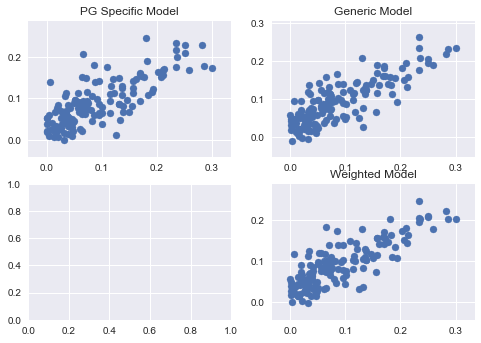

In [185]:
f, axarr = plt.subplots(2, 2)

axarr[0,0].scatter(df_pointguard_averages['Salary%'],pg_model.predict(pg_independent_vars),label='linear')
axarr[0,0].set_title('PG Specific Model')
axarr[0,1].scatter(df_pointguard_averages['Salary%'],gen_model.predict(gen_model_pg_independent_vars),label='linear')
axarr[0,1].set_title('Generic Model')
axarr[1,1].scatter(df_pointguard_averages['Salary%'],model_avg,label='linear')
axarr[1,1].set_title('Weighted Model')
plt.show()